In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Importing the Libraries.
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
#import keras.backend as K
import tensorflow.keras.backend as K
import tensorflow.compat.v1 as tf
from os import listdir
from os.path import isfile, join
import numpy as np
import sys
import os
import shutil
import pandas as pd
from PIL import Image
import cv2
import keras
import glob
from PIL import Image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from keras import models, regularizers, layers, optimizers, losses, metrics
from keras.applications.resnet50 import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, MaxPool2D
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.models import load_model
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from PIL import ImageFile

tf.enable_eager_execution()

In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
# Data Augmentation.
DataGenerator = ImageDataGenerator(horizontal_flip=True, vertical_flip=True, rescale=1./255, brightness_range=[0.2,0.7], zoom_range=[0.5,1.0])

In [ ]:
TestGenerator = ImageDataGenerator(rescale=1./255)

In [ ]:
Grey_TrainingData = DataGenerator.flow_from_directory('/content/drive/My Drive/DTD dataset/dtd/Train/', target_size=(224,224), batch_size=8, color_mode='grayscale')

Found 5075 images belonging to 47 classes.


In [ ]:
Grey_ValidData = TestGenerator.flow_from_directory('/content/drive/My Drive/DTD dataset/dtd/Valid/', target_size=(224,224), batch_size=8, color_mode='grayscale')

Found 282 images belonging to 47 classes.


In [ ]:
gpu_options = tf.GPUOptions(allow_growth=True)
session = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [ ]:
from keras.applications import VGG16

In [ ]:
conv_base = VGG16(weights='imagenet', include_top= False )

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in conv_base.layers[:15]:
  layer.trainable = False
for layer in conv_base.layers[15:]:
  layer.trainable = True

In [ ]:
for i, layer in enumerate(conv_base.layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [ ]:
from keras.layers import Input

In [ ]:
input_tensor = Input(shape=(224,224,1))
x =Conv2D(3,(3,3), padding='same')(input_tensor)
x = conv_base(x)
x = Flatten()(x)

In [ ]:
x = Dense(2048, activation='relu', kernel_regularizer= regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

In [ ]:
ouput = Dense(47, activation='softmax')(x)

In [ ]:
model = Model(inputs = input_tensor, outputs = ouput )

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 3)       30        
_________________________________________________________________
vgg16 (Functional)           (None, None, None, 512)   14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 2048)              51382272  
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)             

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/1-piece/Hardwood/VGG16_DTD.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 20,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = model.fit_generator(steps_per_epoch=634,generator= Grey_TrainingData, validation_data= Grey_ValidData, validation_steps=35,epochs=100,callbacks=callBacks)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
634/634 [==============================] - ETA: 0s - loss: 5.2847 - accuracy: 0.0543
Epoch 00001: val_loss improved from inf to 5.41061, saving model to /content/drive/My Drive/1-piece/Hardwood/VGG16_DTD.h5
634/634 [==============================] - 1927s 3s/step - loss: 5.2847 - accuracy: 0.0543 - val_loss: 5.4106 - val_accuracy: 0.1214
Epoch 2/100
634/634 [==============================] - ETA: 0s - loss: 4.0653 - accuracy: 0.0894
Epoch 00002: val_loss did not improve from 5.41061
634/634 [==============================] - 69s 109ms/step - loss: 4.0653 - accuracy: 0.0894 - val_loss: 31.0611 - val_accuracy: 0.0250
Epoch 3/100
634/634 [==============================] - ETA: 0s - loss: 3.9643 - accuracy: 0.0963
Epoch 00003: val_loss did not improve from 5.41061
634/634 [==============================] - 66s 103ms/step - loss: 3.9643 - accuracy: 0.0963 - val_loss: 7.0412 - val_accuracy: 0.0464
Epoch 4

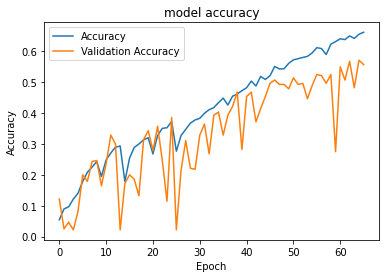

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

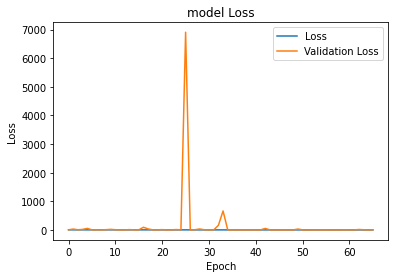

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
GreyTestData = TestGenerator.flow_from_directory('/content/drive/My Drive/DTD dataset/dtd/Test/', target_size=(224,224), batch_size = 8, shuffle = False, color_mode='grayscale')

Found 283 images belonging to 47 classes.


In [ ]:
model.load_weights('/content/drive/My Drive/1-piece/Hardwood/VGG16_DTD.h5')

In [ ]:
Grey_predict = model.predict(GreyTestData)

In [ ]:
Grey_predict_classes = np.argmax(Grey_predict, axis=1)

In [ ]:
Grey_predict_classes

array([22, 29,  0,  0, 29,  0, 23,  9,  3, 29, 23, 37,  2, 45, 45, 44, 45,
        4,  9,  9, 23,  3,  3, 32, 20, 31,  4, 40,  3,  3,  9, 16,  5,  5,
       18,  5,  6,  6,  6,  6,  6,  6,  7, 32,  7,  7, 38, 21, 19, 25, 12,
        8, 45,  8,  9,  9,  9,  9,  9,  3, 10, 30, 10, 18, 10,  3, 24, 23,
       23, 24, 11, 11,  8, 12, 12, 12, 30, 12, 13, 13, 36,  3, 32, 37,  9,
       14, 14, 45, 14, 14, 22, 15, 29,  9, 14,  6, 27, 25, 16, 25, 25,  5,
       17, 17, 29, 35, 17, 17, 18, 18, 18, 25, 18,  3, 35, 19, 19, 19, 19,
       41, 12, 44, 20, 20, 44, 38, 41, 21, 29, 14, 21, 26, 22, 22, 22, 22,
       29, 22, 21, 12,  1,  9, 23,  9, 32,  1, 38, 38, 24, 24, 25, 18, 16,
       44, 43, 25, 26,  3, 26, 26, 26, 41, 27, 27, 44, 10, 40, 10,  3,  3,
        1, 12,  4,  3, 29, 29,  5, 29, 29, 29, 10, 10,  5, 30, 30, 10, 12,
        1, 12, 20, 36, 28, 32, 32,  9, 32, 32, 32, 33, 20,  5, 44, 18,  7,
        9,  1, 45, 11, 32, 32, 35, 32, 45, 35, 35, 35, 28, 12, 44,  3, 36,
       26,  9, 32, 32, 37

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
Grey_accuracy = accuracy_score(GreyTestData.classes, Grey_predict_classes)
print("Grey Accuracy: ", Grey_accuracy)

Grey Accuracy:  0.44876325088339225


In [ ]:
Grey_precision = precision_score(GreyTestData.classes, Grey_predict_classes,average="weighted")
print("Grey Precision: ", Grey_precision)

Grey Precision:  0.5200895100188385


In [ ]:
Grey_recall = recall_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("Grey Recall:", Grey_recall)

Grey Recall: 0.44876325088339225


In [ ]:
Grey_f1_score = f1_score(GreyTestData.classes, Grey_predict_classes, average="weighted")
print("F1 score for Grey: ", Grey_f1_score)

F1 score for Grey:  0.4364382895818531


**Processinf for Colour Data.**

In [ ]:
Colour_TrainingData =  DataGenerator.flow_from_directory('/content/drive/My Drive/DTD dataset/dtd/Train/', target_size=(224,224), batch_size=8)

Found 5075 images belonging to 47 classes.


In [ ]:
Colour_ValidData =  TestGenerator.flow_from_directory('/content/drive/My Drive/DTD dataset/dtd/Valid/', target_size=(224,224), batch_size=8)

Found 282 images belonging to 47 classes.


In [ ]:
conv_base_colour = VGG16(weights = "imagenet", include_top = False)

In [ ]:
for layer in conv_base_colour.layers[:15]:
  layer.trainable = False
for layer in conv_base_colour.layers[15:]:
  layer.trainable = True

In [ ]:
from keras.layers import Input 

In [ ]:
input_tensor = Input(shape=(224,224,3))
x = conv_base_colour(input_tensor)
x = Flatten()(x)
x = Dense(2048, activation='relu', kernel_regularizer= regularizers.l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
ouput = Dense(47, activation='softmax')(x)

In [ ]:
colour_model = Model(inputs = input_tensor, outputs = ouput )

In [ ]:
colour_model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint("/content/drive/My Drive/DTD dataset/dtd/Colour_VGG16.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2,
                              patience = 20,
                              verbose = 1,
                              min_delta = 0.00001)

callBacks = [earlystop, checkpoint, reduce_lr]

In [ ]:
hist = colour_model.fit_generator(steps_per_epoch=634,generator= Colour_TrainingData, validation_data= Colour_ValidData, validation_steps=35,epochs=100,callbacks=callBacks)

Epoch 1/100
634/634 [==============================] - ETA: 0s - loss: 5.0425 - accuracy: 0.0663
Epoch 00001: val_loss improved from inf to 5.08255, saving model to /content/drive/My Drive/DTD dataset/dtd/Colour_VGG16.h5
634/634 [==============================] - 98s 155ms/step - loss: 5.0425 - accuracy: 0.0663 - val_loss: 5.0826 - val_accuracy: 0.0750
Epoch 2/100
634/634 [==============================] - ETA: 0s - loss: 4.1059 - accuracy: 0.0961
Epoch 00002: val_loss did not improve from 5.08255
634/634 [==============================] - 96s 152ms/step - loss: 4.1059 - accuracy: 0.0961 - val_loss: 8.3278 - val_accuracy: 0.0571
Epoch 3/100
634/634 [==============================] - ETA: 0s - loss: 3.8369 - accuracy: 0.1123
Epoch 00003: val_loss improved from 5.08255 to 3.85247, saving model to /content/drive/My Drive/DTD dataset/dtd/Colour_VGG16.h5
634/634 [==============================] - 98s 155ms/step - loss: 3.8369 - accuracy: 0.1123 - val_loss: 3.8525 - val_accuracy: 0.1357
Epoc

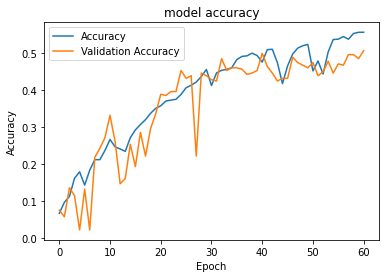

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

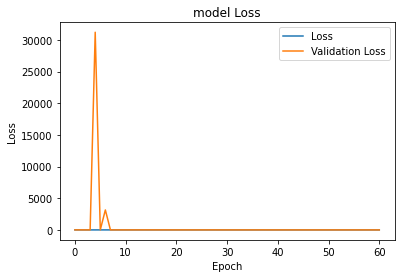

In [ ]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])
plt.show()

In [ ]:
Colour_TestData = TestGenerator.flow_from_directory('/content/drive/My Drive/DTD dataset/dtd/Test/', target_size=(224,224), batch_size = 8, shuffle = False)

Found 283 images belonging to 47 classes.


In [ ]:
colour_model.load_weights('/content/drive/My Drive/DTD dataset/dtd/Colour_VGG16.h5')

In [ ]:
Colour_predict = colour_model.predict(Colour_TestData)

In [ ]:
Colour_predict_classes = np.argmax(Colour_predict, axis=1)

In [ ]:
Colour_predict_classes

array([ 0,  0,  0,  0,  5,  0, 23, 14, 14, 41, 23, 33,  2,  2, 20, 44,  2,
       13,  3, 14, 41, 40,  3, 36, 33,  4, 36, 40,  3,  4,  5,  5,  5,  5,
       18,  5,  6,  6,  6, 17,  6,  6,  7, 32,  7,  7, 23,  7, 19, 44,  8,
        8,  2,  8, 23,  9,  9,  9,  9, 14, 10, 30, 30, 10, 10, 10, 26, 23,
       23, 24, 11, 26, 12, 12,  3, 32, 17,  3, 13, 13, 36, 36, 13, 13, 14,
       14, 14, 35, 14, 14, 15, 15, 17,  9, 33, 15, 16, 16, 16, 16, 16,  5,
       17, 17, 42, 39, 17, 17,  9, 18, 42, 25,  5, 18, 19,  6, 26, 19, 21,
       26, 20, 20, 20, 20, 21, 20, 26, 21, 21, 21, 21, 26, 17, 22, 22, 22,
       22, 22,  3, 28, 15, 14, 23, 23,  3, 24, 23,  1, 24, 39, 25, 25, 16,
       27, 16, 25, 26,  3, 26, 26, 26, 26, 16, 30, 27, 10, 40, 30,  3, 31,
       36, 28, 36, 31, 29, 17, 17, 17, 29, 29, 27, 10, 30, 30, 30, 10, 32,
       12, 23, 28, 13, 28, 32, 32, 32, 32, 32, 32, 18, 44, 20, 33, 33,  6,
        9, 36, 42, 24, 36, 13, 35, 14, 45, 35, 35, 35, 36, 12, 16, 36, 36,
       36, 15,  9, 35,  1

In [ ]:
Colour_accuracy = accuracy_score(Colour_TestData.classes, Colour_predict_classes)
print("Colour Accuracy: ", Colour_accuracy)

Colour Accuracy:  0.5371024734982333


In [ ]:
Colour_precision = precision_score(Colour_TestData.classes, Colour_predict_classes,average="weighted")
print("Colour Precision: ", Colour_precision)

Colour Precision:  0.565186521370267


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Colour_recall = recall_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("Colour Recall:", Colour_recall)

Colour Recall: 0.5371024734982333


In [ ]:
Colour_f1_score = f1_score(Colour_TestData.classes, Colour_predict_classes, average="weighted")
print("F1 score for colour: ", Colour_f1_score)

F1 score for colour:  0.5197832882546642


In [ ]:
Final = 0.6* Colour_predict + 0.4* Grey_predict

In [ ]:
Final_Predict_classes = np.argmax(Final, axis=1)

In [ ]:
Final_accuracy = accuracy_score(Colour_TestData.classes, Final_Predict_classes)
print("Colour Accuracy: ", Final_accuracy)

Colour Accuracy:  0.568904593639576


In [ ]:
Final_precision = precision_score(Colour_TestData.classes, Final_Predict_classes,average="weighted")
print("Colour Precision: ", Final_precision)

Colour Precision:  0.594601864566529


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Final_recall = recall_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("Colour Recall:", Final_recall)

Colour Recall: 0.568904593639576


In [ ]:
Final_f1_score = f1_score(Colour_TestData.classes, Final_Predict_classes, average="weighted")
print("F1 score for colour: ", Final_f1_score)

F1 score for colour:  0.5469212702280563


In [ ]:
Second_final = 0.5* Colour_predict + 0.5* Grey_predict

In [ ]:
Second_Final_Predict_classes = np.argmax(Second_final, axis=1)

In [ ]:
Mean_Final_accuracy = accuracy_score(Colour_TestData.classes, Second_Final_Predict_classes)
print("Colour Accuracy: ", Mean_Final_accuracy)

Colour Accuracy:  0.5547703180212014


In [ ]:
Mean_Precision = precision_score(Colour_TestData.classes, Second_Final_Predict_classes, average="weighted")
Mean_Precision

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.5724538418001316

In [ ]:
Mean_Recall = recall_score(Colour_TestData.classes, Second_Final_Predict_classes, average="weighted")
Mean_Recall

0.5547703180212014

In [ ]:
Mean_F1Score = f1_score(Colour_TestData.classes, Second_Final_Predict_classes, average="weighted")
Mean_F1Score

0.5342075578408981

In [ ]:
Final = 0.8* Colour_predict + 0.2* Grey_predict

In [ ]:
Final_Predict_classes = np.argmax(Final, axis=1)

In [ ]:
Final_accuracy = accuracy_score(Colour_TestData.classes, Final_Predict_classes)
print("Colour Accuracy: ", Final_accuracy)

Colour Accuracy:  0.5406360424028268
